<a href="https://colab.research.google.com/github/Wilson30678tw/Week4-NeuralNetworks/blob/my_branch/W4_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
#importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

In [1]:

def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

In [3]:
def preprocess_waveform(waveform):
    # If the waveform has 2 channels (stereo), convert it to mono
    if len(waveform.shape) > 1:
        waveform = librosa.to_mono(waveform)
    return waveform

In [4]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # make sure the file is mono channel audio
        waveform = preprocess_waveform(waveform)
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

LOAD DATA

In [5]:
#Emotions in the RAVDESS dataset
emotions_dict ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [13]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/Audio Data/Audio_Speech_Actors_01-24/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions_dict[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{1440} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

In [14]:
features, emotions = load_data()

 Processed 1440/1440 audio samples 

In [15]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
features_df.to_csv('featuresRavdess.csv')

#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display
emotions_df.to_csv('emotionsRavdess.csv')



Audio samples represented: 1440
Numerical features extracted per sample: 180


Read File

In [25]:
features=pd.read_csv('featuresRavdess.csv',index_col=0)
emotions=pd.read_csv('emotionsRavdess.csv',index_col=0)

In [58]:
my_features=pd.read_csv('/content/drive/MyDrive/my_audio_featuresRavdess.csv',index_col=0)
my_emotions=pd.read_csv('/content/drive/MyDrive/my_audio_emotionsRavdess.csv',index_col=0)

In [35]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
labels_df=pd.DataFrame(emotions)


Audio samples represented: 1440
Numerical features extracted per sample: 180


In [60]:
print(f'\nAudio samples represented: {my_features.shape[0]}')
print(f'Numerical features extracted per sample: {my_features.shape[1]}')
my_features_df = pd.DataFrame(my_features) # make it pretty for display
my_labels_df=pd.DataFrame(my_emotions)


Audio samples represented: 8
Numerical features extracted per sample: 180


In [34]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.iloc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.iloc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.iloc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.310,     max = 1.000,     mean = 0.667,     deviation = 0.088

128 Mel Spectrogram features:     min = 0.000,     max = 149.208,     mean = 0.188,     deviation = 1.603

40 MFCC features:                 min = -1131.371,    max = 115.126,    mean = -15.072,    deviation = 100.103


In [61]:
print_features(my_features_df)

12 Chromagram features:           min = 0.461,     max = 0.777,     mean = 0.661,     deviation = 0.065

128 Mel Spectrogram features:     min = 0.001,     max = 85.337,     mean = 2.606,     deviation = 6.642

40 MFCC features:                 min = -369.303,    max = 148.436,    mean = -5.763,    deviation = 56.117


Model

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)


scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)


In [71]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

# print('\033[1m'+'My Standard Scaling:\n'+'\033[0m')
# features_scaled_df = pd.DataFrame(my_features_scaled)
# print_features(my_features_scaled_df)

# print('\n\n\033[1m'+'My MinMax Scaling:\n'+'\033[0m')
# features_minmax_df = pd.DataFrame(my_features_minmax)
# print_features(my_features_minmax_df)


Standard Scaling:

12 Chromagram features:           min = -3.897,     max = 4.369,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.474,     max = 36.543,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -4.804,    max = 6.240,    mean = -0.000,    deviation = 1.000
MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.478,     deviation = 0.145

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.014,     deviation = 0.060

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.414,    deviation = 0.170


In [74]:
# Standard
print('\033[1m' + 'My Standard Scaling:\n' + '\033[0m')
scaler_standard = StandardScaler()
my_features_scaled = scaler_standard.fit_transform(my_features)
my_features_scaled_df = pd.DataFrame(my_features_scaled, columns=my_features.columns)
print_features(my_features_scaled_df)

# MinMax
print('\n\n\033[1m' + 'My MinMax Scaling:\n' + '\033[0m')
scaler_minmax = MinMaxScaler()
my_features_minmax = scaler_minmax.fit_transform(my_features)
my_features_minmax_df = pd.DataFrame(my_features_minmax, columns=my_features.columns)
print_features(my_features_minmax_df)

My Standard Scaling:

12 Chromagram features:           min = -2.291,     max = 1.584,     mean = 0.000,     deviation = 1.006

128 Mel Spectrogram features:     min = -1.904,     max = 2.624,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -2.491,    max = 2.427,    mean = -0.000,    deviation = 1.002


My MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.602,     deviation = 0.323

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.349,     deviation = 0.339

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.476,    deviation = 0.340


MLP

In [75]:
from sklearn.model_selection import train_test_split
############# Unscaled test/train set #############
X_train80, X_test, y_train80, y_test = train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=42
)

# Then further divide the train set into validation
# Note that here, to get 60%-20%, we'll need to divide the 80% train set from above to 75-25 split
# 0.8 * 0.25 = 0.2
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train80,
    y_train80,
    test_size=0.25,
    random_state=42
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled80, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

# Repeat to get validation, same as above
X_train_scaled, X_validation_scaled, _, _ = train_test_split(
    X_train_scaled80,
    y_train80,
    test_size=0.25,
    random_state=42
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax80, X_test_minmax, _, _ = train_test_split(
    features_minmax,
    emotions,
    test_size=0.2,
    random_state=42
)

# And get validation set
X_train_minmax, X_validation_minmax, _, _ = train_test_split(
    X_train_minmax80,
    y_train80,
    test_size=0.25,
    random_state=42
)

MLP Initialization

In [76]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
model = MLPClassifier(
    random_state = 42
)

# Use the split train test to train, we'll first use the unscaled parameters
model.fit(X_train, y_train)

print(f'Possible emotions predicted by model:{model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on validation set is {100*model.score(X_validation, y_validation):.2f}%')



Possible emotions predicted by model:['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Unscaled MLP Model's accuracy on training set is 58.22%
Unscaled MLP Model's accuracy on validation set is 41.67%


In [77]:
# Fit the model again on the minmax scaled features
model.fit(X_train_minmax, y_train)

print(f'MinMax scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'MinMax sacled MLP Model\'s accuracy on validation set is {100*model.score(X_validation_minmax, y_validation):.2f}%\n')


# Fit the model again on the scaled features
model.fit(X_train_scaled, y_train)

print(f'Standard scaled MLP Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Standard scaled MLP Model\'s accuracy on validation set is {100*model.score(X_validation_scaled, y_validation):.2f}%')

MinMax scaled MLP Model's accuracy on training set is 64.00%
MinMax sacled MLP Model's accuracy on validation set is 46.53%

Standard scaled MLP Model's accuracy on training set is 99.42%
Standard scaled MLP Model's accuracy on validation set is 60.42%


Choice of Hyperparameters

In [78]:
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend


# Now that we know standard scaling is best for our features, we'll use those for our training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)


# Initialize the MLP Classifier and choose parameters we want to keep constant
model = MLPClassifier(
    # tune batch size later
    batch_size=256,
    # keep random state constant to accurately compare subsequent models
    random_state=42
)

# Choose the grid of hyperparameters we want to use for Grid Search to build our candidate models
parameter_space = {
    # A single hidden layer of size between 8 (output classes) and 180 (input features) neurons is most probable
    # It's a bad idea at guessing the number of hidden layers to have
    # ...but we'll give 2 and 3 hidden layers a shot to reaffirm our suspicions that 1 is best
    'hidden_layer_sizes': [(180,), (300,),(100,50,)],
    'activation': ['relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01],
    #'epsilon': [1e-08, 0.1],
    'learning_rate': ['adaptive', 'constant']
}

# Create a grid search object which will store the scores and hyperparameters of all candidate models
grid = GridSearchCV(
    model,
    parameter_space,
    cv=10, # CV here shows how many fold of cross-validation we'll do
    n_jobs=-1,
    verbose=10)
# Fit the models specified by the parameter grid
# Note that, here we used the whole 80 training set because cross-validation holds out validation sets automatically
# So we won't be using 60-20 split, GridSearchCV will automatically do it
with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)


# get the best hyperparameters from grid search object with its best_params_ attribute
print('Best parameters found:\n', grid.best_params_)

[CV 1/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 2/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 2/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.397 total time=  10.3s
[CV 3/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 1/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.517 total time=  10.5s
[CV 4/10; 1/48] START activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd
[CV 3/10; 1/48] END activation=relu, alpha=0.001, hidden_layer_sizes=(180,), learning_rate=adaptive, solver=sgd;, score=0.452 total time=   9.9s
[CV 5/10; 1/48] START activation=relu, alpha=0

Training and Evaluating the MLP Model

In [89]:

# Now we know best parameters from the Hyperparameter tuning
# We can use them for the final model
model = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=0.01,
    batch_size=256,
    hidden_layer_sizes=(300,),
    learning_rate='adaptive',
    max_iter=1000, # I've found for this task, loss converges at ~1000 iterations
    random_state=42,
)

# In the final model, we can use the whole training dataset
model.fit(X_train, y_train)

print(f'MLP Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
# As we're done with hyperparameter tuning, we can check accuracy on test set
# Note that, up to this point, we did not touch the test set at all
print(f'MLP Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

MLP Model's accuracy on training set is 99.74%
MLP Model's accuracy on test set is 66.32%


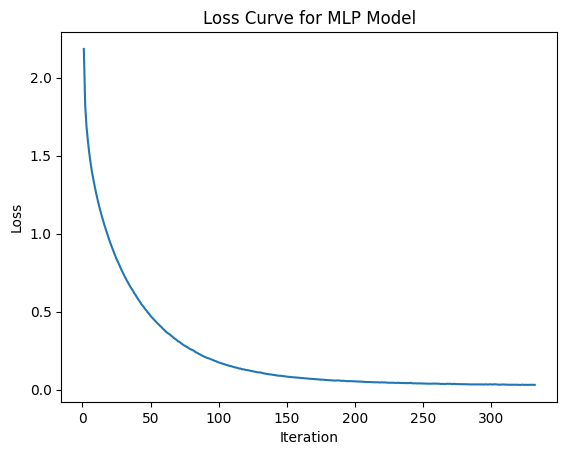

In [80]:
plt.figure()
plt.plot([num for num in range(1,model.n_iter_ +1)], model.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

In [90]:
# Test Org
print('\n\033[1m' + 'Testing Original features data:\n' + '\033[0m')
y_pred_my_original = model.predict(my_features)
accuracy_my_original = accuracy_score(my_emotions, y_pred_my_original)
print(f'MLP Model\'s accuracy on my original features is {100*accuracy_my_original:.2f}%')

# Test my data with Standardrized
print('\n\033[1m' + 'Testing on Standardrized my features data:\n' + '\033[0m')
y_pred_my_standard = model.predict(my_features_scaled_df)
accuracy_my_standard = accuracy_score(my_emotions, y_pred_my_standard)
print(f'MLP Model\'s accuracy standardized on my features is {100*accuracy_my_standard:.2f}%')

#
print('\n\033[1m' + 'Testing my MinMax Scaled features data:\n' + '\033[0m')
y_pred_my_minmax = model.predict(my_features_minmax_df)
accuracy_my_minmax = accuracy_score(my_emotions, y_pred_my_minmax)
print(f'MLP Model\'s accuracy MinMax on my scaled features is {100*accuracy_my_minmax:.2f}%')


Testing Original features data:

MLP Model's accuracy on my original features is 12.50%

Testing on Standardrized my features data:

MLP Model's accuracy standardized on my features is 50.00%

Testing my MinMax Scaled features data:

MLP Model's accuracy MinMax on my scaled features is 25.00%


The Confusion Matrix

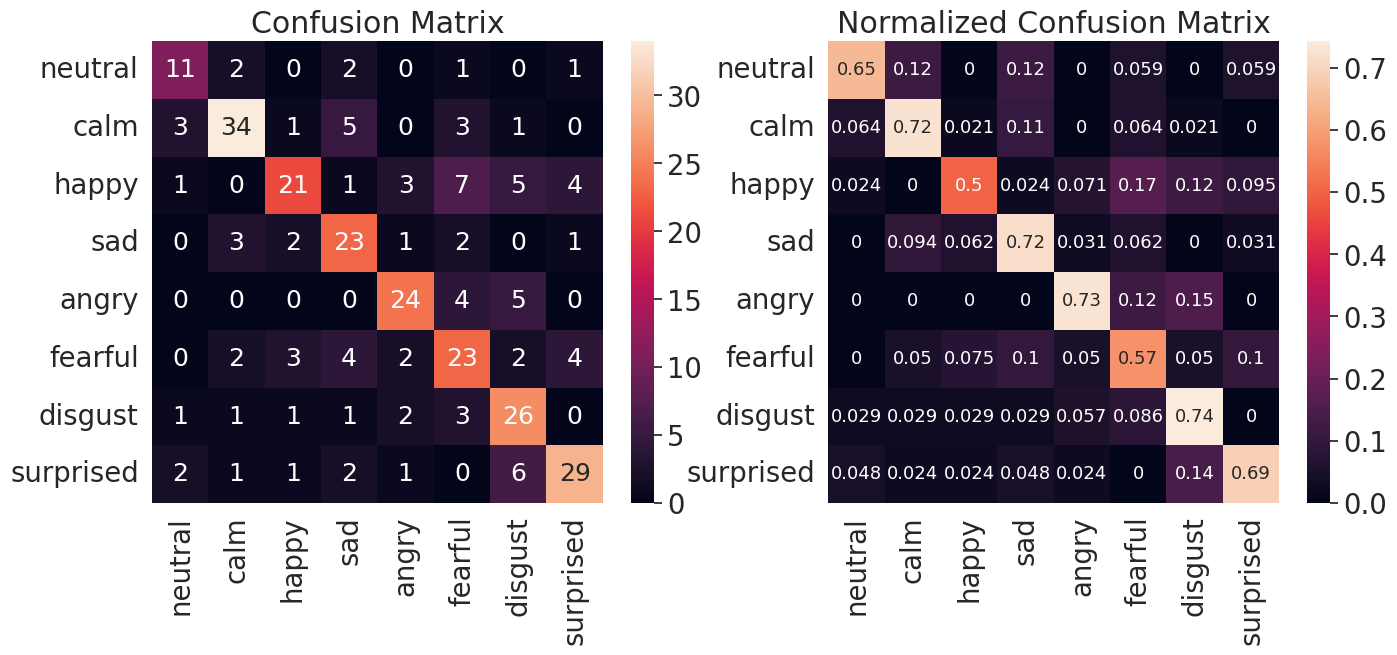

In [84]:
from sklearn.metrics import confusion_matrix
import seaborn as sn # I like seaborn's confusion matrix over sklearn's default

# get predictions on test set
test_emotion_predictions = model.predict(X_test)
test_emotion_groundtruth = y_test

# set labels for matrix axes from emotions
emotion_list =['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
conf_matrix = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions, labels=emotion_list)
conf_matrix_norm = confusion_matrix(test_emotion_groundtruth, test_emotion_predictions,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
confmatrix_df = pd.DataFrame(conf_matrix, index=emotion_name, columns=emotion_name)
confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

Mine Confusion

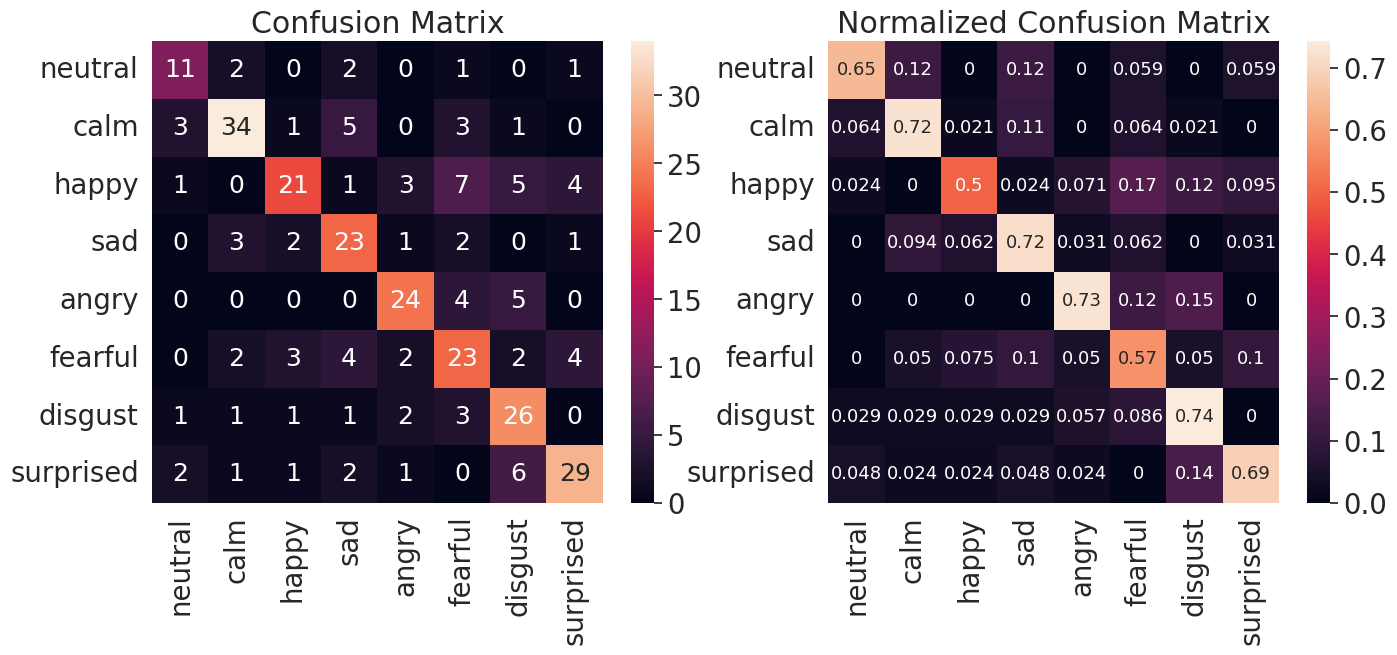

In [92]:
# get predictions on test set
y_pred_emotion = model.predict(my_features_scaled_df)
y_pred_emotion_groundtruth = my_emotions

# set labels for matrix axes from emotions
emotion_list =['neutral','calm','happy','sad','angry','fearful','disgust','surprised']
emotion_name = [emotion for emotion in emotion_list]

# build confusion matrix and normalized confusion matrix
my_conf_matrix = confusion_matrix(y_pred_emotion_groundtruth, y_pred_emotion, labels=emotion_list)
my_conf_matrix_norm = confusion_matrix(y_pred_emotion_groundtruth, y_pred_emotion,normalize='true', labels=emotion_list)



# make a confusion matrix with labels using a DataFrame
my_confmatrix_df = pd.DataFrame(my_conf_matrix, index=emotion_name, columns=emotion_name)
my_confmatrix_df_norm = pd.DataFrame(my_conf_matrix_norm, index=emotion_name, columns=emotion_name)

# plot confusion matrices
plt.figure(figsize=(16,6))
sn.set(font_scale=1.8) # emotion label and title size
plt.subplot(1,2,1)
plt.title('Confusion Matrix')
sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
plt.subplot(1,2,2)
plt.title('Normalized Confusion Matrix')
sn.heatmap(confmatrix_df_norm, annot=True, annot_kws={"size": 13}) #annot_kws is value font

plt.show()

F1 Score

In [93]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y_pred = model.predict(X_test)
print(f'Test Set Accuracy score =  {100*accuracy_score(y_test, y_pred):.3f}%') #same as model.score(X_test, y_test)
print(f'Test Set Precision score =  {100*precision_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set Recall score =  {100*recall_score(y_test, y_pred, average="macro"):.3f}%')
print(f'Test Set F-score score =  {100*f1_score(y_test, y_pred, average="macro"):.3}%')

Test Set Accuracy score =  66.319%
Test Set Precision score =  66.434%
Test Set Recall score =  66.560%
Test Set F-score score =  66.0%


K-Fold Cross-Validation

In [94]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(
    n_splits=10,
    random_state=42,
    shuffle=True
)

scores = []
X_train=pd.DataFrame(X_train)
y_train=pd.DataFrame(y_train)
for train_indices, validation_indices in kfold.split(X_train,y_train):



    train_x=X_train.iloc[train_indices]
    train_y=y_train.iloc[train_indices]

    validation_x=X_train.iloc[validation_indices]
    validation_y=y_train.iloc[validation_indices]
    # fit model to training fold
    model.fit(train_x, train_y)
    # score the model on validation fold
    scores.append(model.score(validation_x, validation_y))

print('KFold CV scores for MLP:');[print(f'{(100*score):.2f}%') for score in scores]
print(f'Mean score of KFold CV for MLP: {100*np.mean(scores):.2f}% ± {100*np.std(scores):.2f}%')

KFold CV scores for MLP:
63.79%
67.24%
65.22%
66.96%
73.04%
62.61%
66.09%
61.74%
70.43%
71.30%
Mean score of KFold CV for MLP: 66.84% ± 3.58%


Learning Curve

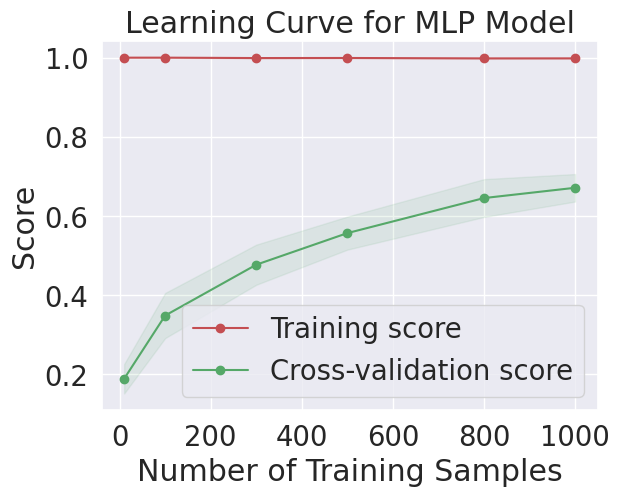

In [95]:
from sklearn.model_selection import learning_curve

# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X=X_train,
    y=y_train,
    cv=10,
    shuffle=True,
    random_state=42,
    n_jobs=4,
    # We have (0.8*1440)/10 = 115/1150 training samples, 1035/1150 test samples
    train_sizes=[10,100,300,500,800, 1000] # bounded at 1035 for this dataset for 10-fold cv
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()